## Preliminares.

#### Contexto

A continuación se presenta un problema clásico en el análisis de texto: Extraer la polaridad
de sentimiento asociado a un texto.<br>
Para esto, utilizaremos una base de datos provenientes de CrowdFlower que se entrega
como archivo adjunto para esta prueba bajo el nombre de training_tweets.csv

#### Etapa 1: Enmarcar el problema 
**¿Cuál es el objetivo del problema?**
El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si
un tweet tiene una polaridad positiva o negativa en cuanto al sentimiento que expresa

Para alcanzar el objetivo general, nuestro trabajo se puede desagregar en los siguientes puntos:
+ Generar un análisis exploratorio sobre los datos contenidos en el DataFrame, considerando palabras más comunes y distribución de las clases en el vector objetivo.


+ <b>Preprocesamiento de Texto</b>:
    -  Para preprocesar los tweets, debemos transformarlos a lower case.
    - Un problema recurrente en el análisis de texto es la alta ocurrencia de palabras comunes. Las eliminaremos mediante la declaración de <b> stopwords</b>.
    - Refinaremos los atributos a capturar mediante el proceso de <b>lemantización</b> (la reducción de variadas palabras con un tronco léxico común)
    - <b>Stemming</b> (la reducción de una palabra a una expresión generalizable). Cabe destacar que ésta carece de análisis morfológico del lenguaje.
    - Representar cada oración en una matriz (o corpus) que permitirá reflejar la cantidad de ocurrencias de W palabra en un registro
    
    
+ Como estrategia de muestreo ocuparemos un 67% de la base de datos para el entrenamiento del modelo, y nos guardaremos un .33 de la muestra. Esto se hace para evitar un sobreajuste a los datos (Overfitting). También haremos uso de la tecnica de <B>SMOTE</B> para combatir el problema de clase desbalanceadas.


+  Preparación del vector objetivo y las matrices de entrenamiento y validación:
    - Nos interesa trabajar con dos tipos de emociones: positivas o negativas. Para ello generaremos la recodificación de cada una de las clases en una de las dos emociones.
    - Si el tweet está asignado como neutral, lo clasificaremos aleatoriamente entre positivo o negativo.




<b>Modelización</b>:
 En base a la búsqueda de la problematica, se ejecutarán diversos modelos de manera basal(sin hiperparámetros), para luego generar grillas de hiperparametros.   

<b>Modelos a evaluar</b>.
  - Model Logistic Regression:
    * Grilla de hiperámetros: 
                    [{"penalty": ["l1", "l2", "elasticnet"],
                    "C" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}] 
  - Support Vector Machines
    * Grilla de hiperparámetros:
                    [(penalty: "l1, l2"), (loss: "hinge, squared_hinde"),
                    (c: "0.01, 0.1, 1, 10, 100"), (gamma: "0.01, 0.1, 1, 10, 100")] 
                    
  - Gradient Boosting
    * Grilla de hiperparámetros: (n_estimators: "100, 500, 1000"), (learning_rate: "0.01, 0.1, 0.5, 1, 5, 10"), (subsa,ple: "0.1, 0.3, 0.6, 1")
    
  - Naive Bayes
    * Grilla de hiperparámetros: (alpha: 0.1, 0.3, 0.5, 0.8) 
  - Model KNN Classifier
    * [{"n_neighbors" : [5, 10, 20, 50, 100],
        "leaf_size" : [20, 30, 50]}]

<b>Metricas de desempeño</b>: Haremos uso de la <b>Matriz de confusión</b>. Esta permite observar la cantidad de observaciones predichas de forma correcta e incorrecta. La diagonal principal reporta los casos exitosamente predichos.<br><br>También estaremos usando el <b>Classification report</b> donde encontraremos otras medidas de desempeño, tales como el porcentaje de casos predichos correctamente por sobre el total de caso, esto se conoce como <b>Accuracy</b> (Exactitud), también nos enfocaremos en la <b>Precisión</b>, la cúal responde a la pregunta: ¿Qué proporción de identificaciones positivas fue correcta?, <b>Recall</b>, ¿Qué proporción de positivos reales se identificó correctamente? y <b>F1</b> el cúal es una medida ponderada de Precisión y Recall.

#### Aspectos computacionales.

In [66]:
# Aquí todos los imports
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re
from missingno import matrix
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
# Métricas
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,roc_auc_score

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Funciones 
import funciones as fns

import pickle

**Librerías para el pre-procesamiento**
+ <b>NumPy:</b> Se utiliza numpy para crear vectores y matrices grandes multidimensionales, junto con una gran colección de funciones matemáticas de
alto nivel para operar con ellas.

+ <b>pandas:</b> Escrita como extensión de NumPy para manipulación y análisis de datos. Ofrece estructuras de datos y operaciones para manipular tablas numéricas y series temporales.
+ <b> Natural Language Toolkit (NLTK)</b>: es un conjunto de bibliotecas y programas para el procesamiento del lenguaje natural, lo usaremos para generar la exclucion de stopwords.
+ <b>Imblearn</b> : Esta librería nos mediante el algoritmo de SMOTE, nos ayudará a crear data de manera artificial para un problema común en machine learning, el de las clases desbalanceadas.
    

In [8]:
# Descarga stopwords
#nltk.download('stopwords')
# Descarga wordnet
#nltk.download('wordnet')
# nltk.download('punkt')

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanhernandezrodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanhernandezrodriguez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ivanhernandezrodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Librerias para modelar.

+ <b> Sklearn </b>: Es una biblioteca para aprendizaje automático de software libre, lo usaremos para la modelación, reportar metricas, tambíen para el preprocesamiento de texto.

#### Librerías para la visualización de datos.

+ <b> Matplotlib:</b> La libreria base para la visualizacion, la utilizaremos para editar graficos y fijar figuras.

+ <b>Seaborn</b>: Esta librería nos ayudará a hacer los gráficos para la visualización de los datos en el analisis exploratorio, importancia de los atributos y reportaje de metricas.

+ <b>WordCloud</b>: Con esta librería crearemos una nube de palabras, asi estamos viendo de forma visual los terminos o palabras con más ocurrencias.

+ <b>Missingno</b>: Esta librería la usaremos para ver de forma visual los datos perdidos en la base de datos.

In [10]:
# Estilo gráficos
plt.style.use('ggplot')

#### Importación Base de Datos.

In [11]:
# Importando base de datos y eliminando columna Unnamed
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0')
# Importando stopwords
stop = stopwords.words('english')

In [12]:
# Forma base de datos
df.shape

(30000, 2)

In [13]:
# Visual de 5 entradas aleatorias
df.sample(5)

,content,sentiment
26682,Listening to shit music.,hate
20365,"got a sniffle, got the kids and hubby just lef...",neutral
16069,Star Trek movie: riveting. Soundtrack: superb....,sadness
10673,is now writing 100-word newsbites http://plur...,sadness
8849,like your first broadcast @supitsemily,love


<b>*Mover esta funcion a un archivo py aux*</b>

In [14]:
def limpiar_tweets_by_reg(txt):
    # Eliminar menciones
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Eliminar hashtag
    txt = re.sub(r'#', '', txt)
    # Eliminar retweets
    txt = re.sub(r'RT : ', '', txt)
    # Eliminar urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

## I) Análisis Exploratorio previo al preprocesamiento.

In [15]:
# Explorando tipo de datos de las columnas.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    30000 non-null  object
 1   sentiment  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


+ Notamos que los tipos de datos correspondiente a las columnas son objetos.

##### Visualización datos perdidos.

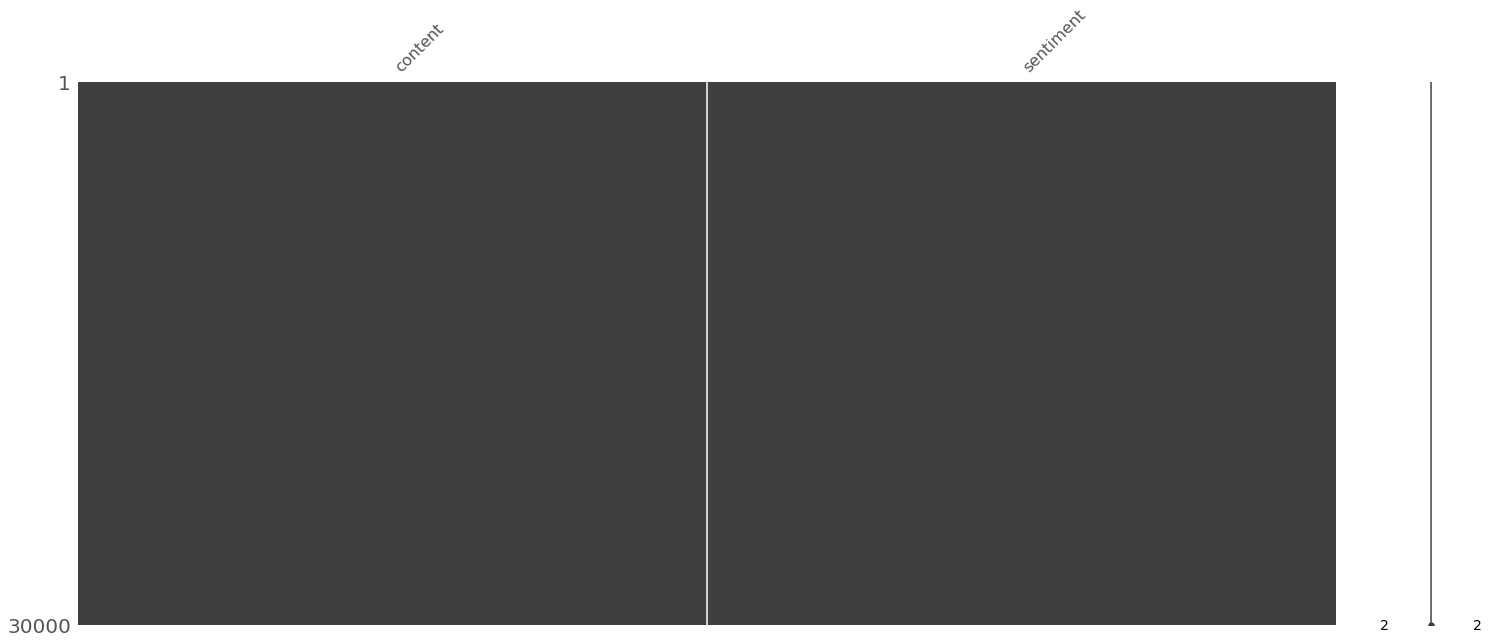

In [16]:
matrix(df);

+ Al no encontrar lineas blancas horizontales, podemos decir que no existen datos perdidos.

##### Distribución vector objetivo.

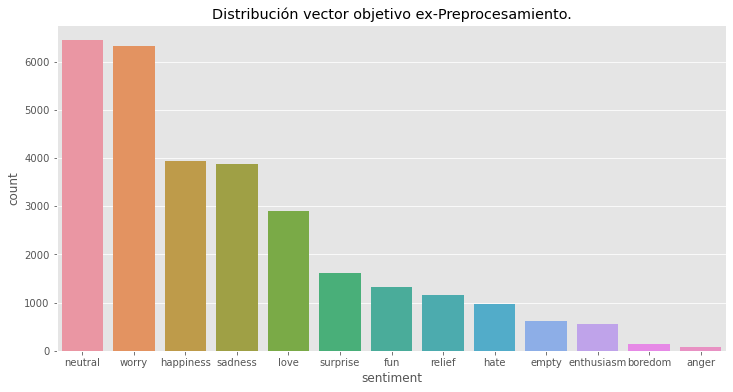

In [17]:
# Creando grafico
plt.figure(figsize=(12,6))
plt.title('Distribución vector objetivo ex-Preprocesamiento.')
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index);

+ Podemos observar que una gran cantidad de tweets son catalogados como neutrales. Un 22% respectivamente, cercano al sentimiento 'worry'.

##### Visualización ocurrencia de terminos.

In [18]:
# Cantidad de ocurrencia de terminos en la base de datos
word_tokens_pre = []
for tweet in df['content']:
    word_tokens_pre.extend(word_tokenize(tweet))
fd_pre = nltk.FreqDist(word_tokens_pre)

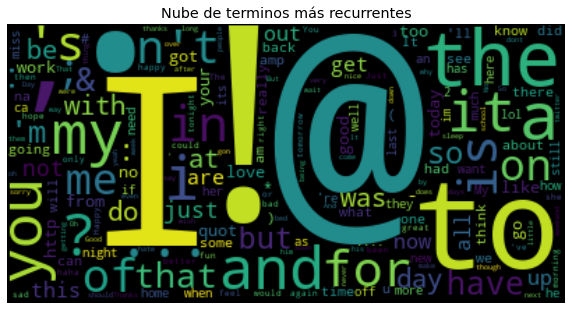

In [19]:
# Creando nube de palabras
wc_pre = WordCloud().generate_from_frequencies(fd_pre)
plt.figure(figsize=(10,10))
plt.title('Nube de terminos más recurrentes')
plt.imshow(wc_pre, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
# Creando df a partir del diccionario de frecuencias
df_fdist = pd.DataFrame.from_dict(fd_pre, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'

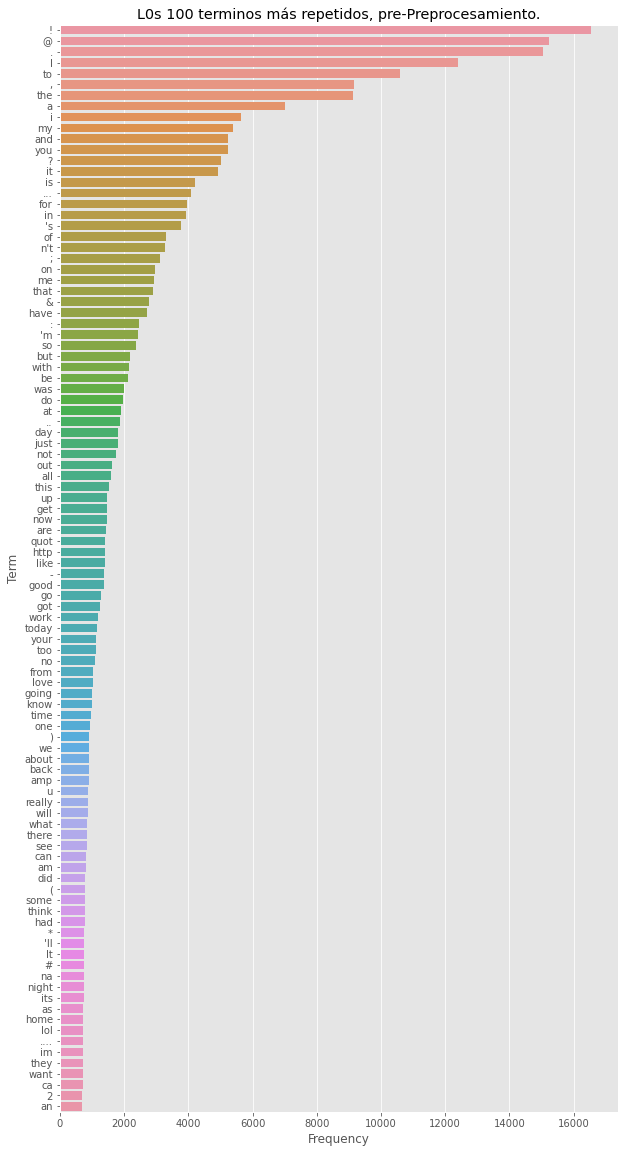

In [21]:
# Graficamos el diccionario
df_fdist_100 = df_fdist.sort_values('Frequency', ascending=False)[0:100]
plt.figure(figsize=(10,20))
plt.title('L0s 100 terminos más repetidos, pre-Preprocesamiento.')
sns.barplot(x='Frequency',y =df_fdist_100.index, data=df_fdist_100);

+ Podemos notar que los terminos más frecuentes son simbolos. Estos los eliminaremos en la limpieza de texto ya que nos generarán ruido.

## II) Feature Engineering.

<b>*Proceso de limpieza de texto*</b>

In [22]:
# Tranformando la serie a minusculas
df['content'] = df['content'].str.lower()
# Limpieza tweets
df['content_paso_1_cl'] = df['content'].apply(limpiar_tweets_by_reg)
# Eliminando stopwords
df['content_paso_2_sw'] = df['content_paso_1_cl'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Lemantización
# Instanciando objeto
lmtzr = WordNetLemmatizer()
# Creando la nueva serie
df['content_paso_3_lm'] = df['content_paso_2_sw'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'v') for word in x.split()]))
# Stemming
# Instanciando objeto
ps = PorterStemmer()
# Creando la nueva serie
df['content_paso_4_st'] = df['content_paso_3_lm'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))
# Eliminando caracteres que no sean letras 
df['content_paso_5_al'] = df['content_paso_4_st'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

##### Eliminación de columnas innecesarias

In [23]:
df = df.drop(columns=['content','content_paso_1_cl','content_paso_2_sw','content_paso_3_lm','content_paso_4_st'])

In [24]:
np.random.seed(1110)
df.sample(5)

,sentiment,content_paso_5_al
29487,sadness,
8499,worry,feel well
9060,love,lol spongebob
22977,empty,ground get caus offici run room place
2736,worry,lol go far tell test today geo zone get like


+ Debido al preprocesamiento de texto, notamos que ahora tenemos algunos valores en blanco. Procederemos a eliminarlos.<br><br>
     <b>*Nota:*</b> *Por fines ilustrativos agregamos una semilla pseudo aleatoria para la replicabilidad de este sample*.<br><br>
+ Para esto remplazaremos el espacio por un valor NaN y posteriormente eliminaremos los NaN.

In [25]:
df[df['content_paso_5_al'] == '']

,sentiment,content_paso_5_al
88,neutral,
137,neutral,
173,relief,
267,sadness,
317,neutral,
...,...,...
29787,neutral,
29872,happiness,
29876,happiness,
29932,worry,


In [26]:
df['content_paso_5_al'] = df['content_paso_5_al'].replace('', np.nan)

In [27]:
df = df.dropna(axis=0)

+ Nueva dimensión del dataframe.

In [28]:
df.shape

(29303, 2)

<b>*Preparación vector objetivo*</b>

In [29]:
negative = ['worry','sadness','hate','empty', 'boredom', 'anger']
positive = ['happiness','love', 'surprise', 'fun', 'relief', 'enthusiasm']

In [30]:
# Semilla aleatoria para replicabilidad
np.random.seed(1110)
# Recodificando vector objetivo
df['sentiment_recod'] = np.where(df['sentiment'].isin(negative), 'negative', np.where(df['sentiment'].isin(positive), 'positive', np.random.choice(['positive', 'negative'],p=(.5,.5))))
# Eliminando la columna previamente recodificada
df = df.drop(columns='sentiment')
# Binarizando vector objetivo
# Aplicamos label encoder
lbl_encoder = LabelEncoder()
df['sentiment_recod'] = lbl_encoder.fit_transform(df['sentiment_recod'])
print('0: {} y 1: {}'.format(lbl_encoder.classes_[0], lbl_encoder.classes_[1]))

0: negative y 1: positive


## III) Análisis Exploratorio post-Preprocesamiento.

In [31]:
# Cantidad de ocurrencia de palabras en la base de datos, diccionario de frecuencias
word_tokens = []
for tweet in df['content_paso_5_al']:
    word_tokens.extend(word_tokenize(tweet))
fd = nltk.FreqDist(word_tokens)

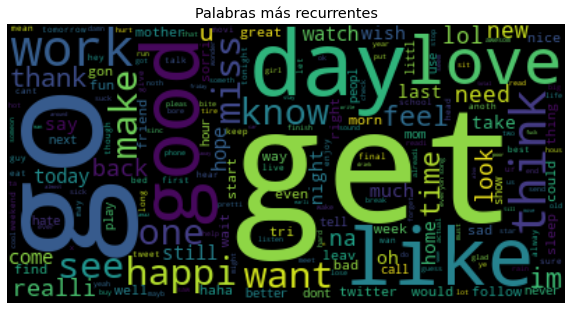

In [32]:
# Creando nube de palabras
wc = WordCloud().generate_from_frequencies(fd)
plt.figure(figsize=(10,10))
plt.title('Palabras más recurrentes')
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
# Creando df a partir del diccionario de frecuencias
df_fdist_post = pd.DataFrame.from_dict(fd, orient='index')
df_fdist_post.columns = ['Frequency']
df_fdist_post.index.name = 'Term'

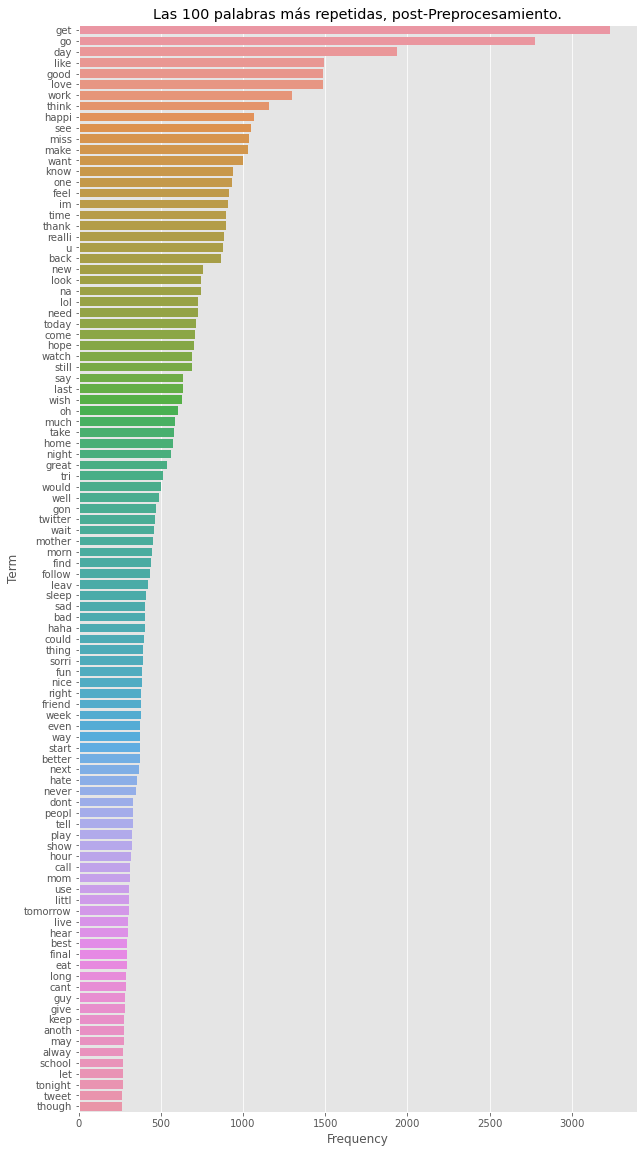

In [34]:
# Graficamos el diccionario
df_fdist_100_post = df_fdist_post.sort_values('Frequency', ascending=False)[0:100]
plt.figure(figsize=(10,20))
plt.title('Las 100 palabras más repetidas, post-Preprocesamiento.')
sns.barplot(x='Frequency',y =df_fdist_100_post.index, data=df_fdist_100_post);

+ Podemos notar que estas palabras mas repetidas, algunas presentan una connotación positiva. 

    Tales como "good", "love" y "happi". 

    Cabe decir que esta ultima palabra "happi" se puede interpretar como todas las palabras que tienen de raiz happi, como "Happines", "Happily" y también "Happy". <br>Lo mismo para las otras dos palabras "good" y "love".


+ Tambien podemos abstraer que el tema trabajar "work", es altamente recurrente en los tweets. Se podría decir que la gente habla más sobre trabajar, trabajos o trabajdores que sobre la felicidad y sus terminos derivados.

##### Visual vector objetivo procesado.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


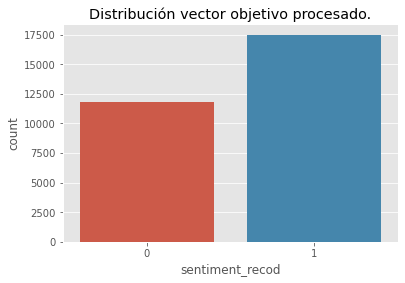

In [35]:
plt.title('Distribución vector objetivo procesado.')
sns.countplot(df['sentiment_recod']);

+ 0 &#8594; Sentimiento Negativo 
+ 1 &#8594; Sentimiento Positivo

+ Podemos notar que en la distribución de nuestro vector objetivo tenemos que una clase  es mayor que la otra. Esto se le conoce como el problema de clases <b>desbalanceadas</b>.

#####  SMOTE

+ Finalmente para el problema de clases desbalanceadas usaremos tecnicas de <b>SMOTE</b>, de esta manera generaremos tweets artificiales para la clase minoritaria.<br><br>

In [36]:
cv = CountVectorizer()
x_train_cv = cv.fit_transform(df['content_paso_5_al'])

In [37]:
# Generando muestras para  vectorizar y hacer smote
y= df['sentiment_recod']
X_train, X_test, y_train, y_test = train_test_split(x_train_cv, y , test_size=.33, random_state=1110)


In [38]:
# Inicializando el smote
#smt = SMOTE(sampling_strategy= 'minority', random_state=1110)
# Generando muestras balanceadas
#X_SMOTE, y_SMOTE = smt.fit_sample(x_train_cv, y_train)

In [39]:
#sns.countplot(y_SMOTE);
#plt.title('Distribucion vector objetivo post SMOTE');

+ Aquí podemos apreciar como las clases están balanceadas después de hacer el SMOTE. 

## IV.- Modelización

En base a los estudios abordados en clases, se implementarán 5 modelos. En donde se presentara una grilla de hiper-parámetros con la finalidad de poder y reportar los escogidos para la modelización. 
Cada modelo ira acompañado con sus respectivas métricas de rendimiento. 
    - Matriz de confusión.
    - Métrica precisión, Exhaustividad y puntuación F1.
    - Accuracy
    
Por último, se escogerán dos modelos en función del las métricas expuestas y costos computacionales. 


### 5.1 - Model Logistic Regression

In [40]:
#Grilla de hiperpárametro
grid_params_LR = [{"C" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
#Modelo Logistic Regression 
LR = GridSearchCV(estimator = LogisticRegression(random_state = 1234),
                  param_grid = grid_params_LR,
                  scoring = "accuracy",
                  n_jobs = -1)

#scoring = Tipo de métrica a utilizar 
#cv= Número de validaciones cruzadas
#n_jobs= se utilizan todos los procesadores disponibles

In [41]:
LR.fit(X_train,y_train)
best_LR= LR.best_estimator_.fit(X_train,y_train)

In [42]:
yhat_LR = fns.reporte_metricas(best_LR, X_test, y_test, "Métricas del Modelo Logistic Regression")
print("Matriz de confusión\n",confusion_matrix(y_test,yhat_LR))

Métricas del Modelo Logistic Regression: 

              precision    recall  f1-score   support

           0       0.71      0.43      0.53      3942
           1       0.69      0.88      0.77      5728

    accuracy                           0.69      9670
   macro avg       0.70      0.65      0.65      9670
weighted avg       0.70      0.69      0.68      9670

Matriz de confusión
 [[1693 2249]
 [ 704 5024]]


In [43]:
acc_train_LR, acc_test_LR, dif_LR = fns.metricas_train_vs_test(best_LR, X_train, X_test, y_train, y_test,
                                                    "Desempeño del Modelo Logestic Regression")

Desempeño del Modelo Logestic Regression: 

Accuracy en entrenamiento: 0.7379
Accuracy en validación: 0.6946
Diferencia del accuracy: 0.0433


### 5.2 - Model Mulinomial Naive Bayes

In [44]:
grid_params_NB = [{"alpha" : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}]

NB =              GridSearchCV(estimator = MultinomialNB(),
                  param_grid = grid_params_NB,
                  scoring = "accuracy", 
                  cv=2,
                  n_jobs= -1)

In [45]:
NB.fit(X_train,y_train)
print("Los mejores parámetros son: ",NB.best_params_)

Los mejores parámetros son:  {'alpha': 1}


In [46]:
best_NB= NB.best_estimator_.fit(X_train,y_train)
yhat_NB = fns.reporte_metricas(best_NB, X_test, y_test, "Métricas del NAIVE BAYES")
print("Matriz de confusión\n",confusion_matrix(y_test,yhat_NB))

Métricas del NAIVE BAYES: 

              precision    recall  f1-score   support

           0       0.63      0.53      0.57      3942
           1       0.71      0.79      0.74      5728

    accuracy                           0.68      9670
   macro avg       0.67      0.66      0.66      9670
weighted avg       0.68      0.68      0.67      9670

Matriz de confusión
 [[2077 1865]
 [1225 4503]]


In [47]:
acc_train_NB, acc_test_NB, dif_NB=fns.metricas_train_vs_test(best_NB, X_train, X_test, y_train, y_test, "Desempeño del Modelo Naive Bayes")

Desempeño del Modelo Naive Bayes: 

Accuracy en entrenamiento: 0.8079
Accuracy en validación: 0.6805
Diferencia del accuracy: 0.1274


### 5.3 - Model Support Vector Machines (SVC)

In [48]:
grid_params_SVC = [{"C": [0.1, 1, 10, 100, 1000],  
                  "gamma" : [1, 0.1, 0.01, 0.001, 0.0001], 
                  "kernel": ["rbf", "poly"]
                  }]
SVC =  GridSearchCV(estimator = SVC(),
                  param_grid = grid_params_LR,
                  scoring = "accuracy", 
                  cv=2,
                  n_jobs= -1)

In [49]:
SVC.fit(X_train,y_train)
print("Los mejores parámetros son: ",SVC.best_params_)

Los mejores parámetros son:  {'C': 1}


In [50]:
best_SVC=SVC.best_estimator_.fit(X_train, y_train)
yhat_SVC = fns.reporte_metricas(best_SVC, X_test, y_test, "Métricas del SUPPORT VECTOR MACHINES")
print("Matriz de confusión\n",confusion_matrix(y_test,yhat_SVC))

Métricas del SUPPORT VECTOR MACHINES: 

              precision    recall  f1-score   support

           0       0.73      0.40      0.52      3942
           1       0.69      0.90      0.78      5728

    accuracy                           0.69      9670
   macro avg       0.71      0.65      0.65      9670
weighted avg       0.70      0.69      0.67      9670

Matriz de confusión
 [[1580 2362]
 [ 591 5137]]


In [51]:
acc_train_SVC, acc_test_SVC, dif_SVC=fns.metricas_train_vs_test(best_SVC, X_train, X_test, y_train, y_test, "Desempeño del Modelo SVC")

Desempeño del Modelo SVC: 

Accuracy en entrenamiento: 0.8772
Accuracy en validación: 0.6946
Diferencia del accuracy: 0.1826


### 5.4 - Model Gradient Boosting

In [52]:
grid_params_GB=[{"learning_rate" : [0.01, 0.1, 0.5],
                   "n_estimators" : [50, 100, 500, 1000, 2000],
                   "subsample" : [0.1,0.5,0.9]
                }]
GB =  GridSearchCV(estimator = GradientBoostingClassifier(random_state = 1234),
                  param_grid = grid_params_GB ,
                  scoring = "accuracy", 
                  cv=2,
                  n_jobs= -1)

In [53]:
GB.fit(X_train,y_train)
print("Los mejores parámetros son: ",GB.best_params_)

Los mejores parámetros son:  {'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5}


In [54]:
best_GB= GB.best_estimator_.fit(X_train, y_train)
yhat_GB = fns.reporte_metricas(best_GB, X_test, y_test, "Métricas del MODEL GRADIENT BOOSTING")

Métricas del MODEL GRADIENT BOOSTING: 

              precision    recall  f1-score   support

           0       0.71      0.42      0.53      3942
           1       0.69      0.88      0.77      5728

    accuracy                           0.69      9670
   macro avg       0.70      0.65      0.65      9670
weighted avg       0.70      0.69      0.67      9670



In [55]:
acc_train_GB, acc_test_GB, dif_GB =fns.metricas_train_vs_test(best_GB, X_train, X_test, y_train, y_test, "Desempeño del Modelo GB")
print("\nPuntuación ROC AUC",roc_auc_score(y_test,yhat_GB))

Desempeño del Modelo GB: 

Accuracy en entrenamiento: 0.7343
Accuracy en validación: 0.6944
Diferencia del accuracy: 0.0399

Puntuación ROC AUC 0.652399740369435


## 5.5 - Model KNN Classifier

In [56]:
grid_params_KNN = [{"n_neighbors" : [5, 10, 20, 50, 100],
                    "leaf_size" : [20, 30, 50]
                  }]

KNN =  GridSearchCV(estimator = KNeighborsClassifier(),
                  param_grid = grid_params_KNN ,
                  scoring = "accuracy", 
                  cv=2,
                  n_jobs= -1)

In [57]:
KNN.fit(X_train,y_train)
print("Los mejores parámetros son: ",KNN.best_params_)

Los mejores parámetros son:  {'leaf_size': 20, 'n_neighbors': 20}


In [58]:
best_KNN= KNN.best_estimator_.fit(X_train, y_train)
yhat_KNN = fns.reporte_metricas(best_KNN, X_test, y_test, "Métricas del MODEL K-NEIGHBORS CLASSIFIER")
print("Matriz de confusión\n",confusion_matrix(y_test,yhat_KNN))

Métricas del MODEL K-NEIGHBORS CLASSIFIER: 

              precision    recall  f1-score   support

           0       0.70      0.22      0.34      3942
           1       0.64      0.93      0.76      5728

    accuracy                           0.64      9670
   macro avg       0.67      0.58      0.55      9670
weighted avg       0.66      0.64      0.59      9670

Matriz de confusión
 [[ 874 3068]
 [ 375 5353]]


In [59]:
acc_train_KNN, acc_test_KNN, dif_KNN=fns.metricas_train_vs_test(best_KNN, X_train, X_test, y_train, y_test, "Desempeño del Modelo KNN")

Desempeño del Modelo KNN: 

Accuracy en entrenamiento: 0.6712
Accuracy en validación: 0.6440
Diferencia del accuracy: 0.0273


### 5.6 - Comparación de los modelos 

In [60]:
model = ["Logistic Regression","Mulinomial Naive Bayes","Support Vector Machines","Gradient Boosting","KNN Classifier"]
Acc_train = [acc_train_LR, acc_train_NB, acc_train_SVC, acc_train_GB, acc_train_KNN]
Acc_train = list(np.around(np.array(Acc_train),2))

Acc_test = [acc_test_LR, acc_test_NB, acc_test_SVC, acc_test_GB, acc_test_KNN]
Acc_test = list(np.around(np.array(Acc_test),2))

diff = [dif_LR, dif_NB, dif_SVC, dif_GB, dif_LR, dif_KNN]
diff = list(np.around(np.array(diff),2))

ROC_AUC=[roc_auc_score(y_test,yhat_LR),roc_auc_score(y_test,yhat_NB),roc_auc_score(y_test,yhat_SVC),
         roc_auc_score(y_test,yhat_GB),roc_auc_score(y_test,yhat_KNN)]
ROC_AUC = list(np.around(np.array(ROC_AUC),3))

df_desemp= df = pd.DataFrame(list(zip(model,Acc_train,Acc_test,diff,ROC_AUC)), columns = ['Name model','Accuracy_Train',"Accuracy_Test","Difference","ROC_AUC"])
df_desemp

,Name model,Accuracy_Train,Accuracy_Test,Difference,ROC_AUC
0,Logistic Regression,0.74,0.69,0.04,0.653
1,Mulinomial Naive Bayes,0.81,0.68,0.13,0.657
2,Support Vector Machines,0.88,0.69,0.18,0.649
3,Gradient Boosting,0.73,0.69,0.04,0.652
4,KNN Classifier,0.67,0.64,0.04,0.578


Text(0.5, 1.0, 'Métricas de desempeño')

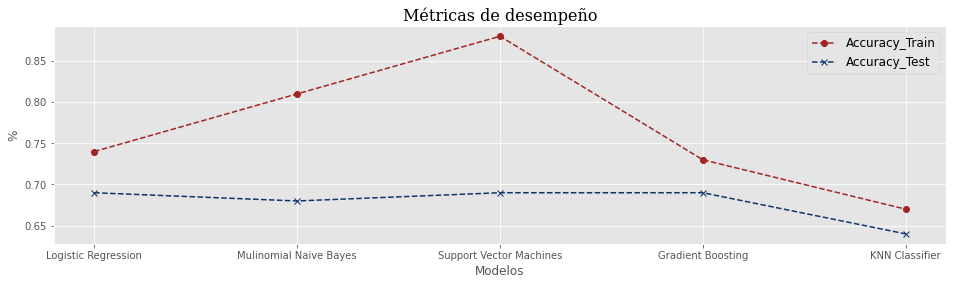

In [61]:
font = {'family': 'serif','weight': 'normal','size': 16,}
plt.figure(figsize=(16,4))
plt.plot(model, Acc_train, color='#a12424', linestyle='--', marker='o')
plt.plot(model, Acc_test, color="#0E3469", linestyle='--', marker='x')

plt.legend(['Accuracy_Train', 'Accuracy_Test'], loc=1,fontsize="large")
plt.ylabel("%",fontdict={"size":12})
plt.xlabel("Modelos", fontdict={"size":12} )
plt.title("Métricas de desempeño", fontdict={'family': 'serif','weight': 'normal','size': 16,})

Text(0.5, 1.0, 'AUC')

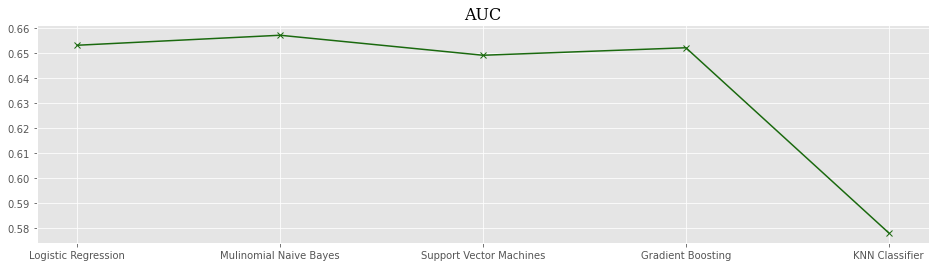

In [62]:
plt.figure(figsize=(16,4))
plt.plot(model, ROC_AUC , color="#1A690E", linestyle='-', marker='x')
plt.title("AUC", fontdict={'family': 'serif','weight': 'normal','size': 16,})

### 6.- Conclusiones

En base a las métricas:
  - **Precision** nos indica cuan preciso y/o exactos son los modelos de los positivos previstos, cuántos de ellos son positivos reales. En este caso para los sentimientos negativos el modelo que se comporta mejor es ***Support Vector Machines*** con 0.73 y el peor ***Naives Bayes*** con 0.63, existienton un una diferencia 10 p.p. 
      En el caso para los sentimientos positivos el modelo que se comporta mejor es ***Naives Bayes*** con 0.71 y el peor ***KNN Classifier*** con 0.64, existienton un una diferencia 7 p.p.
      
      
  - **Recall** calcula cuántos de los positivos reales captura niuestro modelo al etiquetarlo como positivos.nos indica cuan preciso y/o exactos son los modelos de los positivos previstos, cuántos de ellos son positivos reales. En este caso para los sentimientos negativos el modelo que se comporta mejor es ***Support Vector Machines*** con 0.53 y el peor ***KNN Classifier*** con 0.31, existienton un una diferencia 10 p.p. 
      En el caso para los sentimientos positivos el modelo que se comporta mejor es ***KNN Classifier*** con 0.91 y el peor ***Naives Bayes**** con 0.79, existienton un una diferencia 12 p.p. 
      
  
  - **F1** Ponderación entre Recall y Precision. Los mejores modelos fueron ***Logistic Regression, Model Gradient, Boosting,Support Vector Machines*** con 0.69 luego ***Mulinomial Naive Bayes*** con 0.68 y finalmente ***KNN Classifier*** con 0.64. 
  
 En primera instancia podemos definir que de acuerdo Accuracy de testeo todos tienen un 0.69 a diferencia de KNN Classifier que tiene 0.64. Los modelos que podemos encintrar mayor sobreajuste son ***Supoport Vector Machine y Naive Bayes***. 
 
 De acuerdo a puntaje de curva roc_auc podemos identificar que los mejores modelos son: ***Supoport Vector Machine, Logistic Regression y Gradient Boosting***

*De acuerdo a todas las métricas utilizadas se considera que los mejores modelos para continuar el proceso son ***Logistic Regression y Gradient Boosting***, ya que presentan comportamientos similares, no tiene sobreajuste y presentan en la globalidad mejores indicadores que los otros modelos, considerando además un menor costo computacional.*

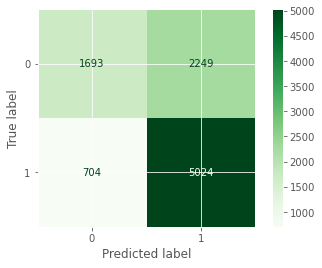

In [63]:
plot_confusion_matrix(best_LR, X_test, y_test, cmap = "Greens")

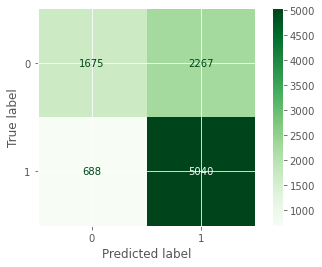

In [65]:
plot_confusion_matrix(best_GB, X_test, y_test, cmap = "Greens")

### 7.- Archivos serializados

In [67]:
pickle.dump(best_LR, open("model_LR.sav", "wb"))
pickle.dump(best_GB, open("model_GB.sav", "wb"))